In [15]:
# # Don't run this cell

# import sys
# sys.path.append('../..')

# from new_caller.student_caller_july.student_caller import CohortCaller
# from new_caller.student_caller_july.student_list import avocoder_toasters

# toaster_caller = CohortCaller(avocoder_toasters)

We will start this code along where we left off with yesterday's standdown activity. Below, the Titanic dataset has been loaded into memory.

In [16]:
import seaborn
import pandas as pd
import numpy as np

titanic = seaborn.load_dataset('titanic')
titanic.sample()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
313,0,3,male,28.0,0,0,7.8958,S,Third,man,True,NaN,Southampton,no,True


Yesterday afternoon, you split the target off from the independent variables, as the cell below does:

In [17]:
# Split the target 'survived' off from the predictors
X = titanic.drop('survived', axis=1)
y = titanic['survived']

You then converted the `sex` column to a binary.

In [18]:
def is_female(sex_record):
    '''
    Transform a column indicating sex by a string
    'male'/'female' to a binary where
    0 = Male
    1 = Female
    '''

    if sex_record == 'male':
        return 0
    else:
        return 1
    
X['sex'] = X['sex'].apply(is_female)


You then split the data into train and test. 

In [19]:
from sklearn.model_selection import train_test_split

# Implement a train-test split using all default arguments and random_state=42
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

Now we will use cross validation functions to select our best model.

For logistic regression, it has been stressed that we need to scale our data before passing our data into `cross_validate`.  In previous exercise, we have looked the other way at this, or implemented some gnarly KFold code.  KFold is good to know, in case you do need to implement some bespoke cross validation techniques.  However, pipelines will do a lot of the same work, with a lot less code.

Our first pipeline tools come from `sklearn.pipeline`

In [20]:
from sklearn.pipeline import Pipeline, make_pipeline

What is the difference between `Pipeline` and `make_pipeline`?

**With `Pipeline` you have to name your objects. With `make_pipeline` you can use slightly less code and don't have to name your objects.**

# Take 5 minutes with a partner to fill in the code below

To create a pipeline, we pass in different transformers and estimators. For our first pipeline, we will StandardScale our inputs, and then pass them into a LogisticRegression model.  

In [21]:
# pass StandardScaler and LogisticRegression objects (i.e. instances: Think parens) into make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipeline = make_pipeline(StandardScaler(), LogisticRegression(random_state=42))

Below you have been provided with a function that will print out train and test scores given a pipeline and a feature_list.  

In [22]:

from sklearn.model_selection import cross_validate

def print_cv_scores(pipe, feature_list):
    
    # we pass in pipe to cross validate along with a feature list.
    results = cross_validate(pipe, X_train[feature_list], 
                                   y_train, 
                                   return_train_score=True)
    
    print(results['train_score'])
    print(results['train_score'].mean())
    print('##############')
    print(results['test_score'])
    print(results['test_score'].mean())
    


In [23]:
# Pass in the pipeline above along with a list of two continuous variables: 'fare' and 'sex': 
print_cv_scores(pipeline, ['fare', 'sex'])

[0.79213483 0.76966292 0.79588015 0.79439252 0.77757009]
0.7859281038888306
##############
[0.76119403 0.85074627 0.74626866 0.7518797  0.81954887]
0.7859275053304905


In [11]:
pipeline.named_steps

{'standardscaler': StandardScaler(),
 'logisticregression': LogisticRegression()}

The above code ensures that the Standard Scaler and Logistic Regression model are fit only on the training sets of each fold.  There is no leakage.

# End pair task here

Next, we want to add some complexity to the model by adding the feature `class`.  In order to do that.

In [24]:
X_train['class'].value_counts()

Third     375
First     152
Second    141
Name: class, dtype: int64

In order to do so, use a OneHotEncoder to transform the column. Like our other objects, our OneHotEncoder must be fit only on the training set.  The features which it encodes may then, by chance, not include values in the test set of each fold.  If we one hot encoded before the split, this could potentially break our model.  

Sklearn.compose has a handy class called ColumnTransformer. ColumnTransformer will allow us to pair a transformer with the columns that it should act on.

In [25]:
from sklearn.compose import ColumnTransformer


Create a ColumnTransformer object which takes as an argument `transformers` which equals a list of transformers.  For this instance, the list is composed of one transformer, the OneHotEncoder.  We specify the details of the transformer with a tuple that includes 
 - 1: a string we create that names the transformer 
 - 2: the transformer object, i.e. the OneHotEncoder object with arguments `categories="auto", handle_unknown="ignore"` 
 - 3: a list of the feature names it acts on, in this case just `class`. 
 
The second argument after the tupple, `remainder`, describes what to do with the features not acted on by the transformer.  We want the unused features to `passthrough` to the next transformer in the pipeline.

# Take 5 minutes with a parterner to fill in the code below

In [27]:
from sklearn.preprocessing import OneHotEncoder

# Create the column transformer in this cell. 
col_transformer = ColumnTransformer(transformers=[
                                    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['class'])], 
                                    remainder='passthrough')

Create a new pipeline with three arguments: col_transformer, StandardScaler(), and LogisticRegression(random_state=42)

In [28]:
# Create new pipeline here
new_pipe = make_pipeline(col_transformer, 
                         StandardScaler(), 
                         LogisticRegression(random_state=42))

In [29]:
print_cv_scores(new_pipe, ['sex', 'fare', 'class'])

[0.79775281 0.77153558 0.79588015 0.79439252 0.77757009]
0.7874262312296545
##############
[0.76119403 0.85074627 0.74626866 0.7518797  0.81954887]
0.7859275053304905


# End pair here

Run the cell below, and calculate accuracy, precision, recall, and f1 score

In [35]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_hat_train = cross_val_predict(new_pipe, X_train[['sex', 'fare', 'class']], y_train)

confusion_matrix(y_train, y_hat_train)

array([[353,  62],
       [ 81, 172]])

In [38]:
tp = 172
tn = 353
fp = 62
fn = 81

accuracy = (tp + tn) / (tp + tn + fp + fn)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision * recall) / (precision + recall)

In [41]:
print('Accuracy:  ', accuracy)
print('Recall:    ', recall)
print('Precision: ', precision)
print('F1-score:  ', f1)

Accuracy:   0.7859281437125748
Recall:     0.6798418972332015
Precision:  0.7350427350427351
F1-score:   0.7063655030800821


In [ ]:
toaster_caller.call_n_students()

One great thing about pipelines is that they can be used with GridSearchCV.  That way, we can try out different combinations of hyperparameters for the different objects in the pipeline.  

We create a parameter grid which is a dictionary with keys designating the object and the hyperparameter, and values equal to a list of potential values.

The tough thing to remember is the key should have the form of `objectname` + `__` + `hyperparametername`

We can print out the new_pipe, like below, to see the names. 

In [42]:
new_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['class'])])),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=42))])

In the cell below, create a parameter grid that tries out the values `.0001,.5,  1,50, 100` for the `C` hyperparameter.  Remember `C` equals inverse regularization strength.

# Take 3 minutes by yourself to try this

In [57]:
from sklearn.model_selection import GridSearchCV

parameter_grid = {'logisticregression__C': [0.0001, 0.5, 1, 50, 100]}

In [67]:
# Run this cell to fit the grid search.
gs = GridSearchCV(new_pipe, parameter_grid, scoring=None)
gs.fit(X_train[['sex', 'fare', 'class']], y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['class'])])),
                                       ('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(random_state=42))]),
             param_grid={'logisticregression__C': [0.0001, 0.5, 1, 50, 100]})

After fitting, we can access the best_score_ as well as the best_parameters, as shown below

In [68]:
print(gs.best_score_)
print(gs.best_params_)

0.7859275053304905
{'logisticregression__C': 0.5}


We also have the best_estimator_, which has been refit to the entire training set.  We can use that object to make predictions.

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


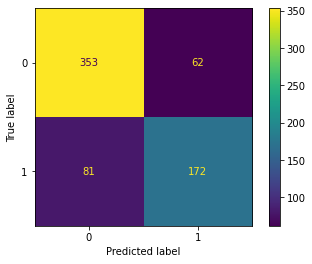

In [69]:
# Run cell without changes
from sklearn.metrics import plot_confusion_matrix

y_hat_train = gs.best_estimator_.predict(X_train[['sex', 'fare', 'class', 'age']])

plot_confusion_matrix(gs.best_estimator_, X_train[['sex', 'fare', 'class', 'age']], y_train)

In [353]:
# Calculate metrics
accuracy = None
precision = None
recall = None
f1_score = None

In [ ]:
toaster_caller.call_n_students()

Although there is not a huge class imbalance, let's see what effect altering the balance may have.  We could use SMOTE (caution: SMOTE only works with imblearn.pipeline objects), but here let's try altering the `class_weight`.  Create a new param_grid with that tests out the same C values above, as well as the class_weight parameters `None` and `balanced`

# Take 5 minutes with a partner to fill in code below

In [78]:
new_parameter_grid = {'logisticregression__C': [0.001, .025, 0.5, 1],
                      'logisticregression__class_weight': [None, 'balanced']}

We can also change what metric we pass into the GridSearch via the `scoring` argument.  Pass in the string `f1` after the new_param_grid argument.

In [81]:
gs = GridSearchCV(new_pipe, new_parameter_grid, scoring='f1')
gs.fit(X_train[['sex', 'fare', 'class']], y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['class'])])),
                                       ('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(random_state=42))]),
             param_grid={'logisticregression__C': [0.001, 0.025, 0.5, 1],
                         'logisticregression__class_weight': [None,
                                                              'balanced']},
             scoring='f1')

In [82]:
print(gs.best_score_)
print(gs.best_estimator_)

0.7051176139734492
Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['class'])])),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    random_state=42))])


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


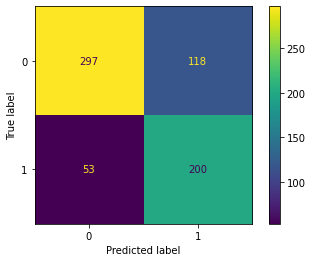

In [83]:
# Run to plot the confusion matrix from the training set.
plot_confusion_matrix(gs.best_estimator_, X_train[['sex', 'fare', 'class', 'age']], y_train)

# End pair

In [360]:
# Calculate metrics
accuracy = None
recall = None
precision = None
f1 = None

In [ ]:
toaster_caller.call_n_students()

Describe why the confusion matrix looks the way it does.  Why are there now less of one error and more of another.

# Stretch Goal

Choose another classifier: KNN, NaiveBayes, DecisionTreeClassifier, and create a pipeline with it.  Use GridSearchCV to search out optimal hyperparameters for that classifier.

In [13]:
# Your code here